In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from collections import deque

import networkx as nx

from scipy import stats





In [3]:

def assign_terrain(neighbor_terrains, terrain_types, transition_matrix):
    num_terrains = len(terrain_types)
    prob_distribution = np.zeros(num_terrains)

    for neighbor_terrain in neighbor_terrains:
        idx = terrain_types.index(neighbor_terrain)
        prob_distribution += transition_matrix[idx]

    prob_distribution /= prob_distribution.sum()
    new_terrain = np.random.choice(terrain_types, p=prob_distribution)

    return new_terrain
def generate_temperature(terrain_type, time, precipitation, temp_params):
    params = temp_params[terrain_type]
    base_temp = params['base_temp']
    diurnal_variation = params['diurnal_variation']
    precipitation_effect = params['precipitation_effect']

    temp_variation = diurnal_variation * np.sin(((time - 6) / 24) * 2 * np.pi)
    temperature = base_temp + temp_variation
    temperature -= precipitation_effect * precipitation
    temperature += np.random.normal(0, 2)
    temperature = np.clip(temperature, -10, 45)
    return temperature

def generate_wind_speed(terrain_type, time, precipitation, wind_params):
    params = wind_params[terrain_type]
    base_wind = params['base_wind']
    time_variation = params['time_variation']
    precipitation_effect = params['precipitation_effect']

    wind_variation = time_variation * np.sin((time / 24) * 2 * np.pi)
    wind_speed = base_wind + wind_variation
    wind_speed += precipitation_effect * precipitation
    wind_speed += np.random.normal(0, 2)
    wind_speed = max(wind_speed, 0)
    wind_speed = np.clip(wind_speed, 0, 100)
    return wind_speed

def generate_visibility(terrain_type, time, precipitation, visibility_params):
    params = visibility_params[terrain_type]
    max_visibility = params['max_visibility']
    time_effect = params['time_effect']
    precipitation_effect = params['precipitation_effect']

    visibility = max_visibility
    if time < 7 or time > 19:
        visibility -= time_effect * (abs(13 - time) / 6)
    visibility -= precipitation_effect * precipitation
    visibility += np.random.normal(0, 2)
    visibility = np.clip(visibility, 0, 100)
    return visibility

def generate_precipitation(terrain_type, precipitation_params):
    """
    Generates precipitation based on terrain type.

    For 'Swampy' and 'Wooded' terrains, precipitation is generated using a gamma distribution with low mean and high variance.
    For other terrains, precipitation is 0 most of the time, with occasional rain.

    Parameters:
    - terrain_type (str): Terrain type of the node.
    - precipitation_params (dict): Parameters for precipitation generation.

    Returns:
    - precipitation (float): Generated precipitation in mm/h.
    """
    params = precipitation_params[terrain_type]

    
    # Use a Bernoulli distribution to decide if it rains
    rain_probability = params['rain_probability']  # e.g., 0.1 for 10% chance of rain
    if np.random.rand() < rain_probability:
        # Generate precipitation from an exponential distribution
        scale = params['scale']  # Mean of the exponential distribution
        precipitation = np.random.exponential(scale=scale)
    else:
        precipitation = 0.0

    precipitation = np.clip(precipitation, 0, 50)
    return precipitation


def simulate_metadata_over_parameters(terrain_types, times, precipitation_params, temp_params, wind_params, visibility_params, num_runs=100):
    """
    Simulates metadata generation over different terrain types and times, running multiple simulations to compute mean and confidence intervals.
    """
    results = []

    for terrain_type in terrain_types:
        for time in times:
            # Lists to store results from multiple runs
            temp_list = []
            wind_speed_list = []
            visibility_list = []
            precipitation_list = []
            
            for _ in range(num_runs):
                # Generate precipitation
                precipitation = generate_precipitation(terrain_type, precipitation_params)
                precipitation_list.append(precipitation)
                
                # Generate temperature
                temperature = generate_temperature(terrain_type, time, precipitation, temp_params)
                temp_list.append(temperature)
                
                # Generate wind speed
                wind_speed = generate_wind_speed(terrain_type, time, precipitation, wind_params)
                wind_speed_list.append(wind_speed)
                
                # Generate visibility
                visibility = generate_visibility(terrain_type, time, precipitation, visibility_params)
                visibility_list.append(visibility)
            
            # Compute mean and confidence intervals
            temp_mean = np.mean(temp_list)
            temp_ci = stats.norm.interval(0.95, loc=temp_mean, scale=stats.sem(temp_list))
            
            wind_speed_mean = np.mean(wind_speed_list)
            wind_speed_ci = stats.norm.interval(0.95, loc=wind_speed_mean, scale=stats.sem(wind_speed_list))
            
            visibility_mean = np.mean(visibility_list)
            visibility_ci = stats.norm.interval(0.95, loc=visibility_mean, scale=stats.sem(visibility_list))
            
            precipitation_mean = np.mean(precipitation_list)
            precipitation_ci = stats.norm.interval(0.95, loc=precipitation_mean, scale=stats.sem(precipitation_list))
            
            results.append({
                'terrain_type': terrain_type,
                'time': time,
                'temperature_mean': temp_mean,
                'temperature_ci': temp_ci,
                'wind_speed_mean': wind_speed_mean,
                'wind_speed_ci': wind_speed_ci,
                'visibility_mean': visibility_mean,
                'visibility_ci': visibility_ci,
                'precipitation_mean': precipitation_mean,
                'precipitation_ci': precipitation_ci
            })

    return results

def generate_random_regular_network(degree, num_nodes, terrain_types, transition_matrix, precipitation_params,
                                    temp_params, wind_params, visibility_params, mine_likelihood, accuracy_params):
    """
    Generates a random regular graph with metadata assigned to each node.

    Parameters:
    - degree (int): Degree of each node in the regular graph.
    - num_nodes (int): Number of nodes in the graph.
    - terrain_types (list): List of terrain types.
    - transition_matrix (np.array): Transition probability matrix.
    - precipitation_params (dict): Precipitation parameters for each terrain type.
    - temp_params (dict): Temperature parameters for each terrain type.
    - wind_params (dict): Wind speed parameters for each terrain type.
    - visibility_params (dict): Visibility parameters for each terrain type.
    - mine_likelihood (float): Percentage (0-1) of nodes that contain mines.

    Returns:
    - G (networkx.Graph): The generated regular graph with node attributes.
    - start_node (int): The start node.
    - end_node (int): The end node (node furthest from start node).
    """
    if degree >= num_nodes:
        raise ValueError("Degree must be less than the number of nodes.")
    if (degree * num_nodes) % 2 != 0:
        raise ValueError("Degree * num_nodes must be even for a regular graph.")

    # Generate a connected random regular graph
    connected = False
    while not connected:
        G = nx.random_regular_graph(degree, num_nodes)
        connected = nx.is_connected(G)

    # Set constant time for all nodes
    current_time = int(np.random.randint(0, 24))

    # Select start node
    start_node = 0

    # Assign random terrain to start node
    start_terrain = np.random.choice(terrain_types)
    nx.set_node_attributes(G, {start_node: start_terrain}, 'terrain')

    # Assign metadata to nodes
    visited = set()
    queue = [start_node]
    visited.add(start_node)

    while queue:
        current_node = queue.pop(0)
        current_terrain = G.nodes[current_node]['terrain']

        # Time is constant across all nodes
        G.nodes[current_node]['time'] = current_time

        # Generate precipitation first
        precipitation = generate_precipitation(current_terrain, precipitation_params)
        G.nodes[current_node]['precipitation'] = precipitation

        # Generate temperature
        temperature = generate_temperature(current_terrain, current_time, precipitation, temp_params)
        G.nodes[current_node]['temperature'] = temperature

        # Generate wind speed
        wind_speed = generate_wind_speed(current_terrain, current_time, precipitation, wind_params)
        G.nodes[current_node]['wind_speed'] = wind_speed

        # Generate visibility
        visibility = generate_visibility(current_terrain, current_time, precipitation, visibility_params)
        G.nodes[current_node]['visibility'] = visibility

        neighbors = list(G.neighbors(current_node))

        for neighbor in neighbors:
            if neighbor not in visited:
                assigned_neighbors = [n for n in G.neighbors(neighbor) if n in visited]
                neighbor_terrains = [G.nodes[n]['terrain'] for n in assigned_neighbors]

                if neighbor_terrains:
                    new_terrain = assign_terrain(neighbor_terrains, terrain_types, transition_matrix)
                else:
                    new_terrain = np.random.choice(terrain_types)

                nx.set_node_attributes(G, {neighbor: new_terrain}, 'terrain')
                visited.add(neighbor)
                queue.append(neighbor)

    

    # Compute shortest paths to find end node
    lengths = nx.single_source_shortest_path_length(G, start_node)
    max_distance = max(lengths.values())
    furthest_nodes = [node for node, dist in lengths.items() if dist == max_distance]
    end_node = furthest_nodes[0]

    # Assign mines to nodes
    num_mines = int((num_nodes - 2) * mine_likelihood)  # Exclude start and end nodes
    possible_mine_nodes = set(G.nodes()) - {start_node, end_node}
    mine_nodes = set(np.random.choice(list(possible_mine_nodes), num_mines, replace=False))

    # Assign mine presence to nodes
    for node in G.nodes():
        G.nodes[node]['mine_presence'] = node in mine_nodes
        
        node_data = G.nodes[node]

        # Retrieve metadata
        temperature = node_data['temperature']
        wind_speed = node_data['wind_speed']
        visibility = node_data['visibility']
        precipitation = node_data['precipitation']
        terrain_type = node_data['terrain']
        mine_presence = node_data['mine_presence']

        # Compute accuracy
        human_accuracy = compute_accuracy(
            temperature, wind_speed, visibility, precipitation, terrain_type, visibility_scale=accuracy_params['human_accuracy_param']
        )
        ai_accuracy = compute_accuracy(
            temperature, wind_speed, visibility, precipitation, terrain_type, visibility_scale=accuracy_params['ai_accuracy_param']
        )
        node_data['human_accuracy'] = float(human_accuracy)
        node_data['ai_accuracy'] = float(ai_accuracy)

        # Compute estimate
        human_estimate = compute_estimates(
            accuracy_values=human_accuracy,
            ground_truth=mine_presence,
            threshold=accuracy_params['human_threshold_param']
        )
        
        ai_estimate = compute_estimates(
            accuracy_values=human_accuracy,
            ground_truth=mine_presence,
            threshold=accuracy_params['ai_threshold_param']
        )

        node_data['human_estimate'] = float(human_estimate)
        node_data['ai_estimate'] = float(ai_estimate)

    # Ensure that start and end nodes do not have mines
    G.nodes[start_node]['mine_presence'] = False
    G.nodes[end_node]['mine_presence'] = False

    return G, start_node, end_node

In [4]:

def visualize_network(G, start_node, end_node):
    terrain_color_map = {
        'Grassy': 'green',
        'Rocky': 'gray',
        'Sandy': 'yellow',
        'Wooded': 'darkgreen',
        'Swampy': 'brown'
    }

    node_colors = []
    for node in G.nodes():
        terrain = G.nodes[node].get('terrain', 'gray')
        if node == start_node:
            node_colors.append('blue')  # Start node in blue
        elif node == end_node:
            node_colors.append('red')   # End node in red
        elif G.nodes[node].get('mine_presence'):
            node_colors.append('black')  # Nodes with mines in black
        else:
            node_colors.append(terrain_color_map.get(terrain, 'gray'))


    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='white')

    plt.title('Random Regular Graph with Terrain Types')
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    terrain_types = ['Grassy', 'Rocky', 'Sandy', 'Wooded', 'Swampy']
    transition_matrix = np.array([
        [0.6, 0.1, 0.1, 0.1, 0.1],  # From Grassy
        [0.1, 0.6, 0.1, 0.1, 0.1],  # From Rocky
        [0.1, 0.1, 0.6, 0.1, 0.1],  # From Sandy
        [0.1, 0.1, 0.1, 0.6, 0.1],  # From Wooded
        [0.1, 0.1, 0.1, 0.1, 0.6],  # From Swampy
    ])

    precipitation_params = {
        'Grassy': {
            'rain_probability': 0.1,  # 10% chance of rain
            'scale': 10  # Mean of exponential distribution when it rains
        },
        'Rocky': {
            'rain_probability': 0.05,  # 5% chance of rain
            'scale': 5
        },
        'Sandy': {
            'rain_probability': 0.02,
            'scale': 4
        },
        'Wooded': {
            'rain_probability': 0.25,
            'scale': 20
        },
        'Swampy': {
            'rain_probability': 0.25,
            'scale': 20
        },
    }

    temp_params = {
        'Grassy': {'base_temp': 20, 'diurnal_variation': 10, 'precipitation_effect': 0.2},
        'Rocky': {'base_temp': 15, 'diurnal_variation': 8, 'precipitation_effect': 0.3},
        'Sandy': {'base_temp': 25, 'diurnal_variation': 12, 'precipitation_effect': 0.1},
        'Wooded': {'base_temp': 18, 'diurnal_variation': 6, 'precipitation_effect': 0.25},
        'Swampy': {'base_temp': 22, 'diurnal_variation': 5, 'precipitation_effect': 0.15},
    }

    wind_params = {
        'Grassy': {'base_wind': 10, 'time_variation': 5, 'precipitation_effect': 0.2},
        'Rocky': {'base_wind': 15, 'time_variation': 4, 'precipitation_effect': 0.3},
        'Sandy': {'base_wind': 12, 'time_variation': 6, 'precipitation_effect': 0.1},
        'Wooded': {'base_wind': 8, 'time_variation': 3, 'precipitation_effect': 0.25},
        'Swampy': {'base_wind': 6, 'time_variation': 2, 'precipitation_effect': 0.15},
    }

    visibility_params = {
        'Grassy': {'max_visibility': 100, 'time_effect': 5, 'precipitation_effect': 2},
        'Rocky': {'max_visibility': 100, 'time_effect': 6, 'precipitation_effect': 2.5},
        'Sandy': {'max_visibility': 100, 'time_effect': 4, 'precipitation_effect': 1.5},
        'Wooded': {'max_visibility': 90, 'time_effect': 8, 'precipitation_effect': 4},
        'Swampy': {'max_visibility': 90, 'time_effect': 10, 'precipitation_effect': 5},
    }


    accuracy_params = {'human_accuracy_param': 0.3,
                       'human_threshold_param': 0.0, 
                       'ai_accuracy_param': 0.55, 
                       'ai_threshold_param': 0.5
    }


    mine_likelihood = 0.2  # 20% of nodes contain mines

    degree = 6
    num_nodes = 100  # Ensure degree * num_nodes is even
    G, start_node, end_node = generate_random_regular_network(
        degree, num_nodes, terrain_types, transition_matrix, precipitation_params,
        temp_params, wind_params, visibility_params, mine_likelihood, accuracy_params
    )
    print(f"Start node: {start_node}")
    print(f"End node: {end_node} (furthest from start node)")

    network = {
        "nodes": [],
        "edges": [],
        "start_node": int(start_node),
        "end_node": int(end_node),
        "mine_likelihood": mine_likelihood,
        "precipitation_params": precipitation_params  # Include the parameters
    }

    for node in G.nodes(data=True):
        node_id = node[0]
        node_data = node[1]

        node_entry = {
            "id": int(node_id),
            "metadata": {
                "terrain": node_data.get('terrain'),
                "time": int(node_data.get('time')),
                "temperature": float(node_data.get('temperature')),
                "wind_speed": float(node_data.get('wind_speed')),
                "visibility": float(node_data.get('visibility')),
                "precipitation": float(node_data.get('precipitation')),
                "human_estimate": float(node_data.get('human_estimate')),
                "ai_estimate": float(node_data.get('ai_estimate'))
            },
            "inaccessible": {
                "mine_presence": bool(node_data.get('mine_presence')),
                "human_accuracy": float(node_data.get('human_accuracy')),
                "ai_accuracy": float(node_data.get('ai_accuracy')),
                
            }
        }
        network["nodes"].append(node_entry)

    for edge in G.edges():
        source, target = edge
        network["edges"].append({"source": int(source), "target": int(target)})

    # Print the network JSON
    print(json.dumps(network, indent=4))

    # Visualize the network
    visualize_network(G, start_node, end_node)

NameError: name 'compute_accuracy' is not defined

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


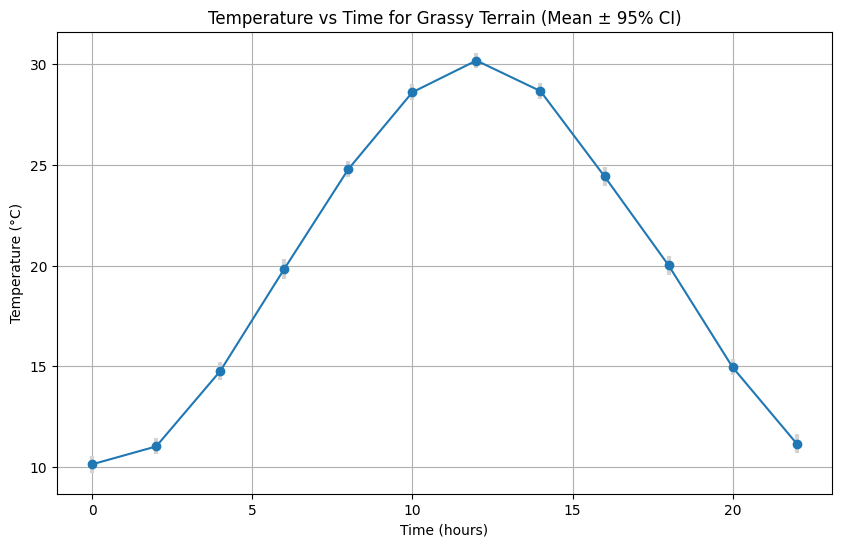

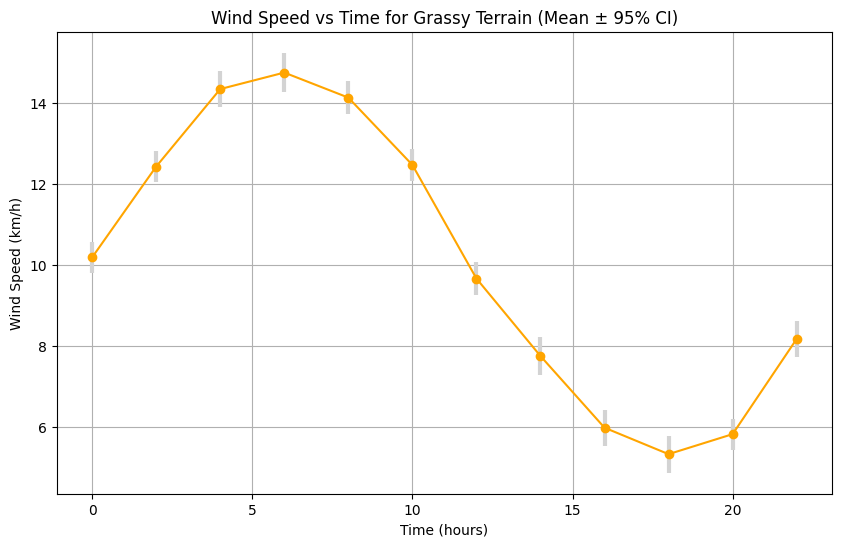

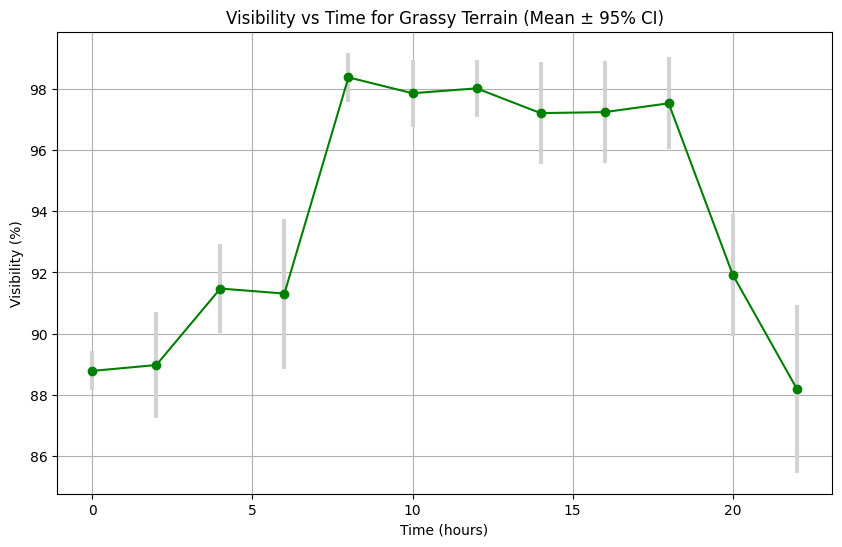

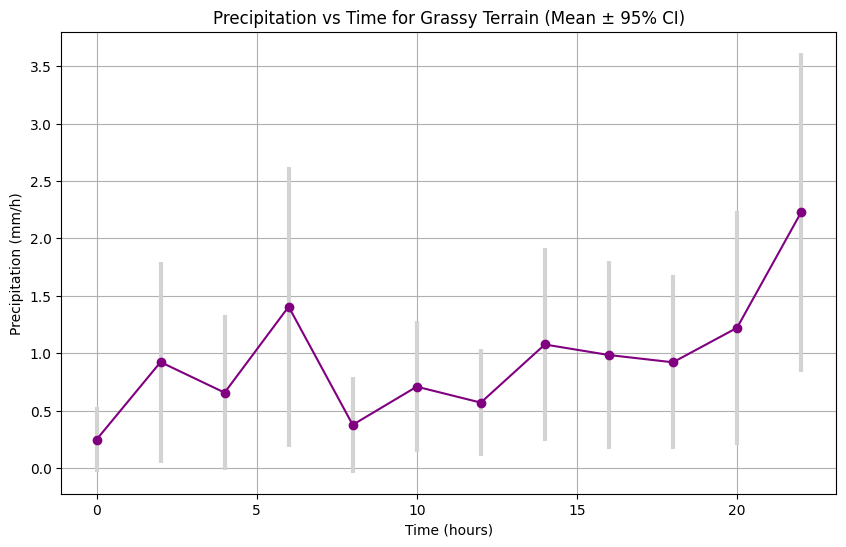

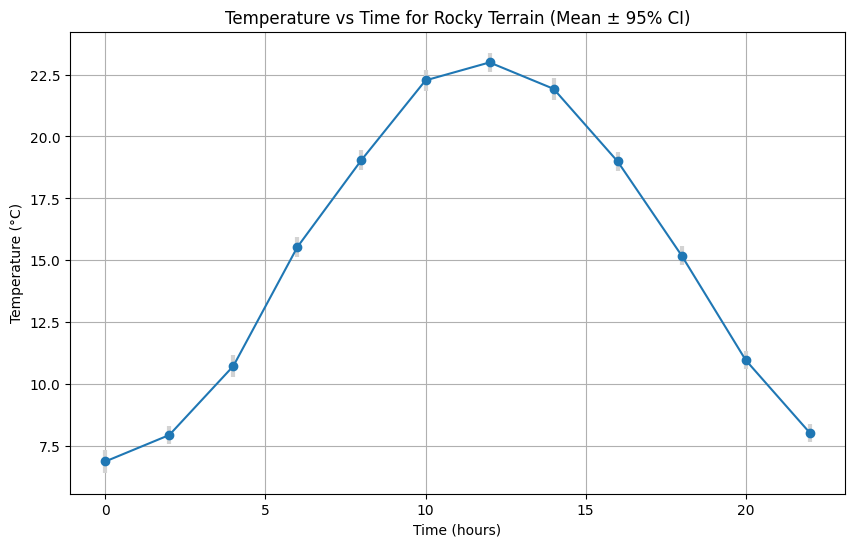

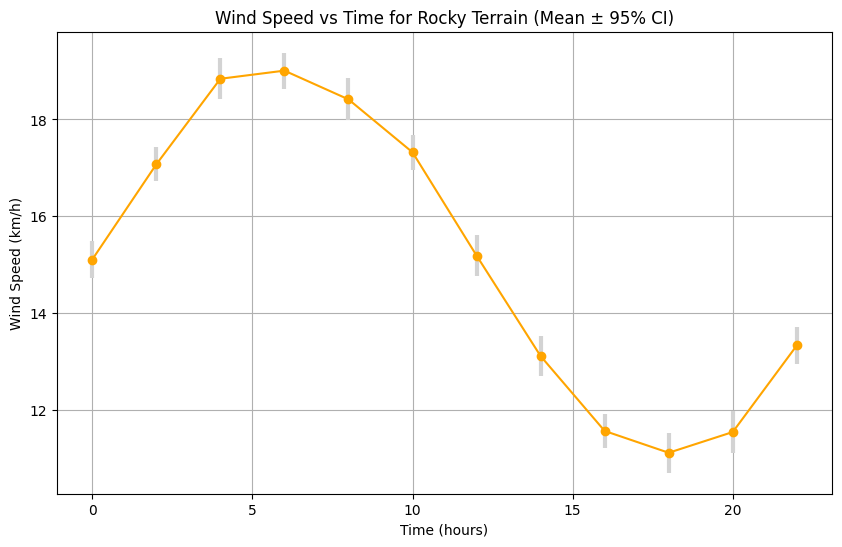

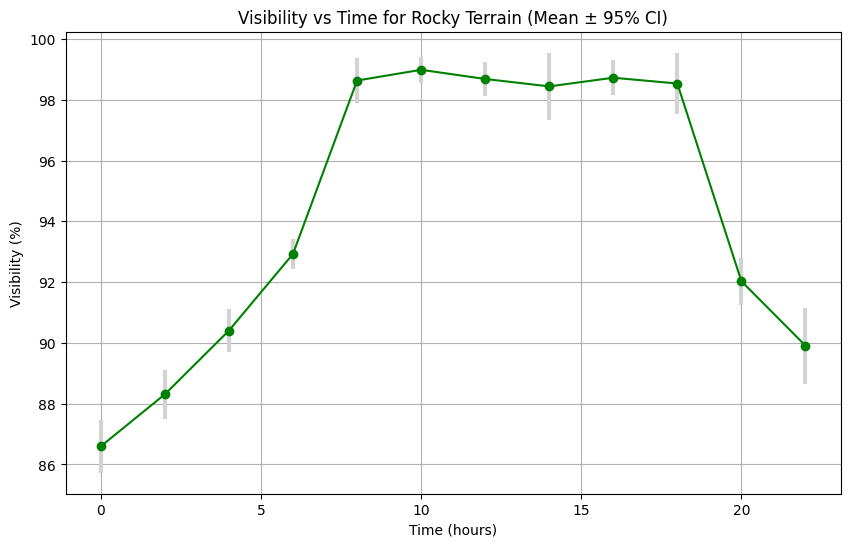

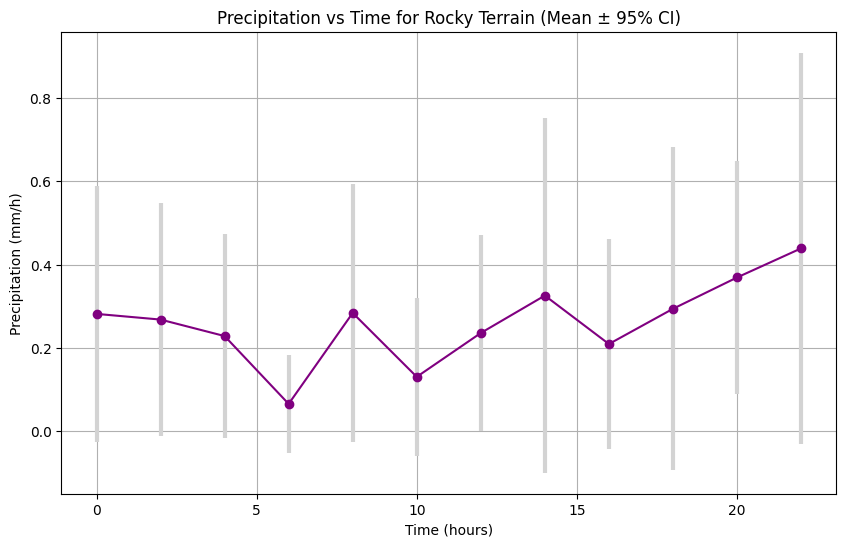

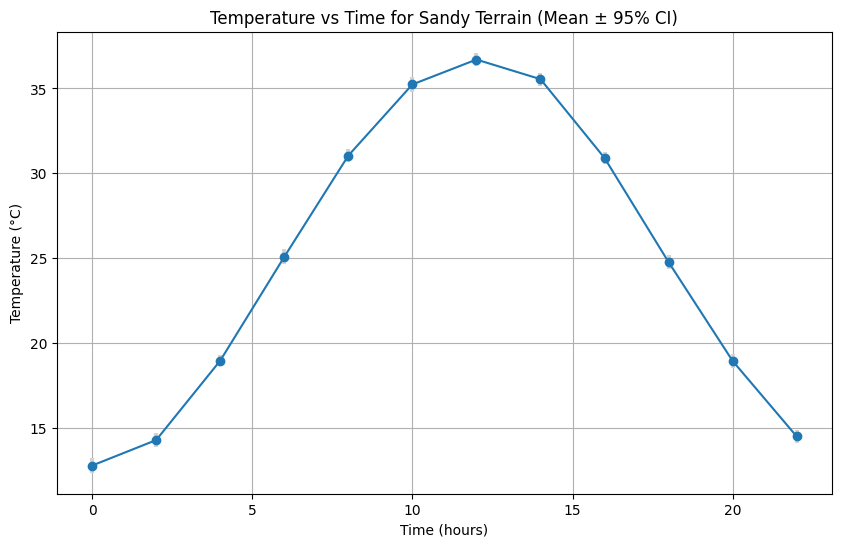

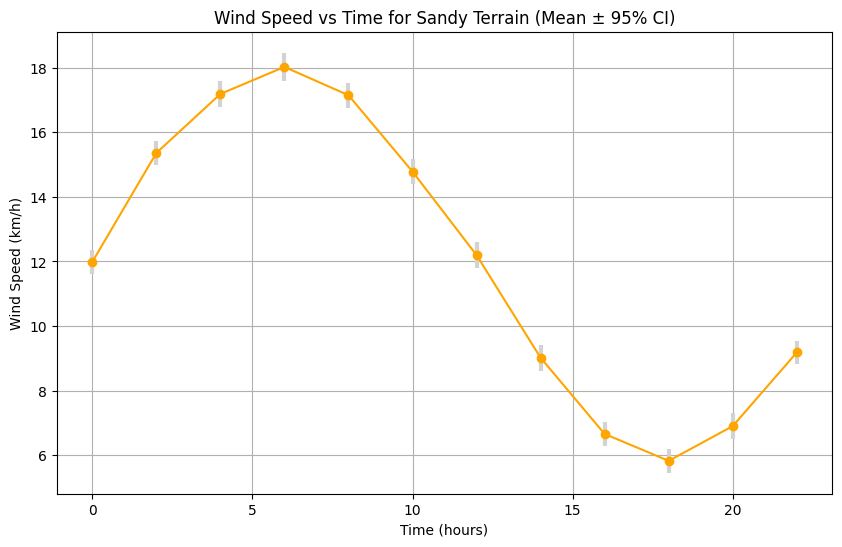

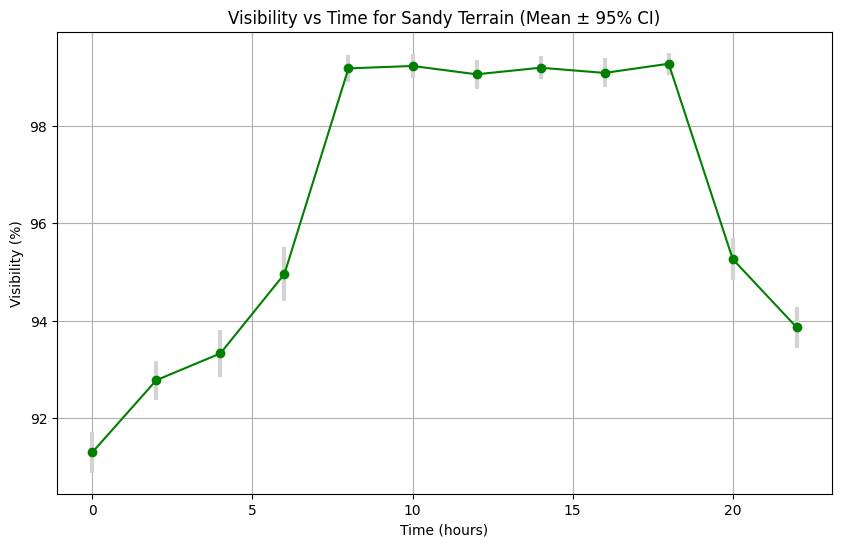

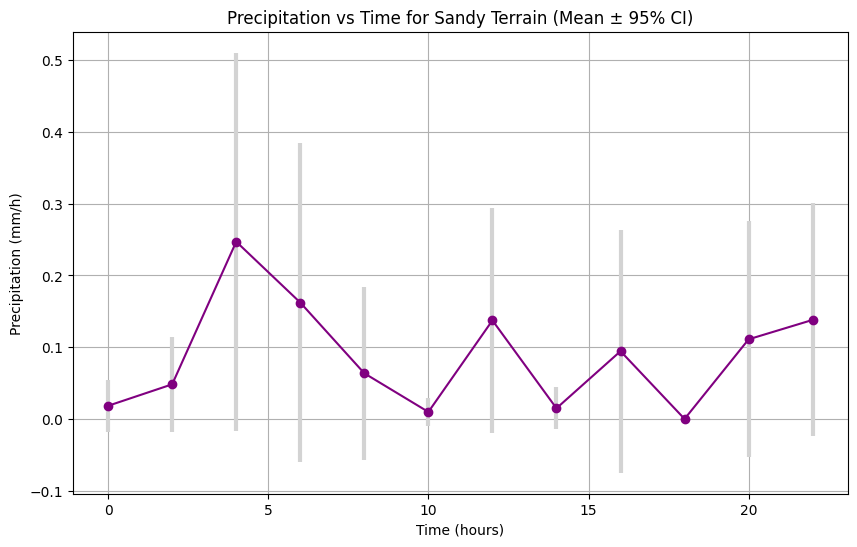

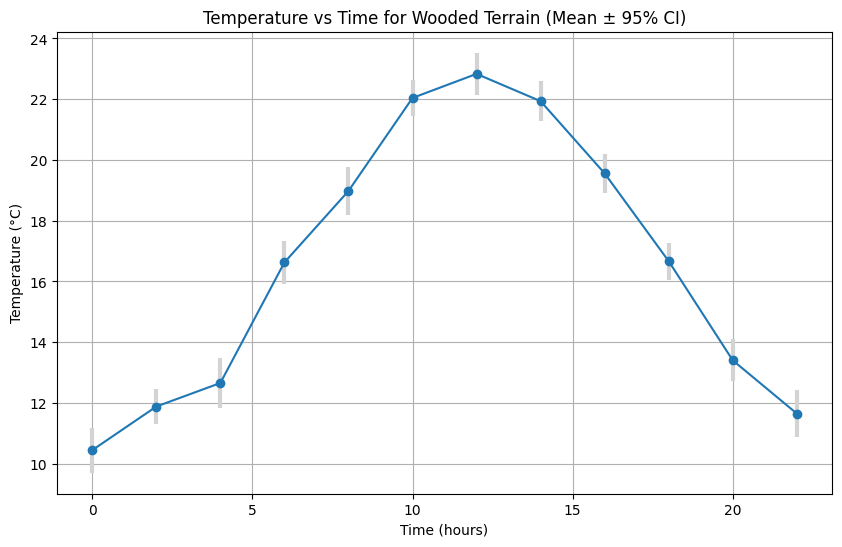

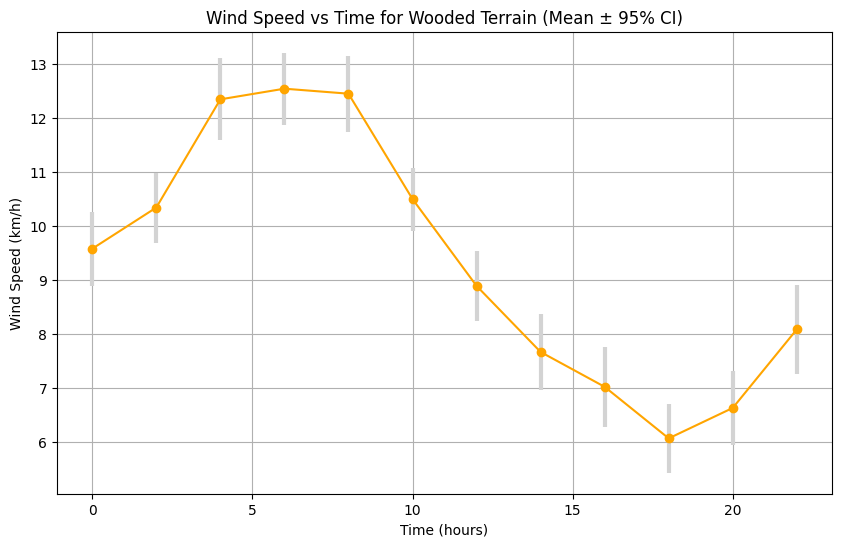

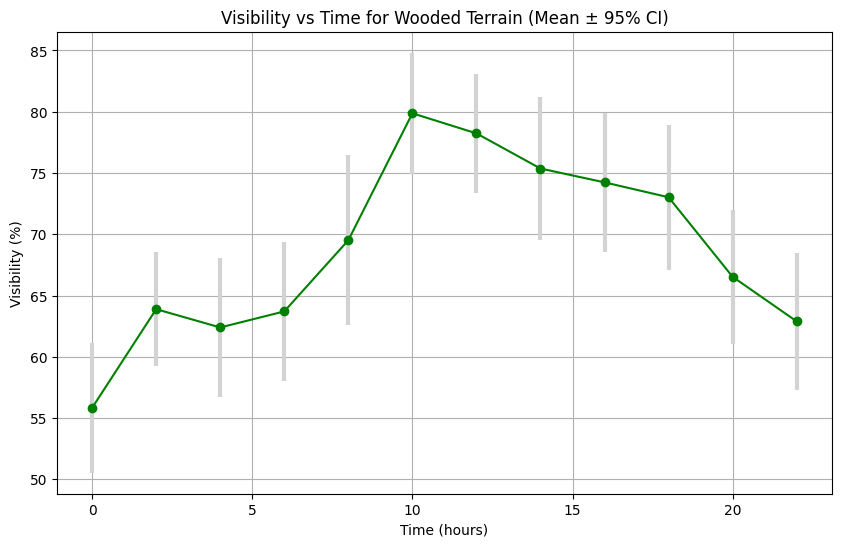

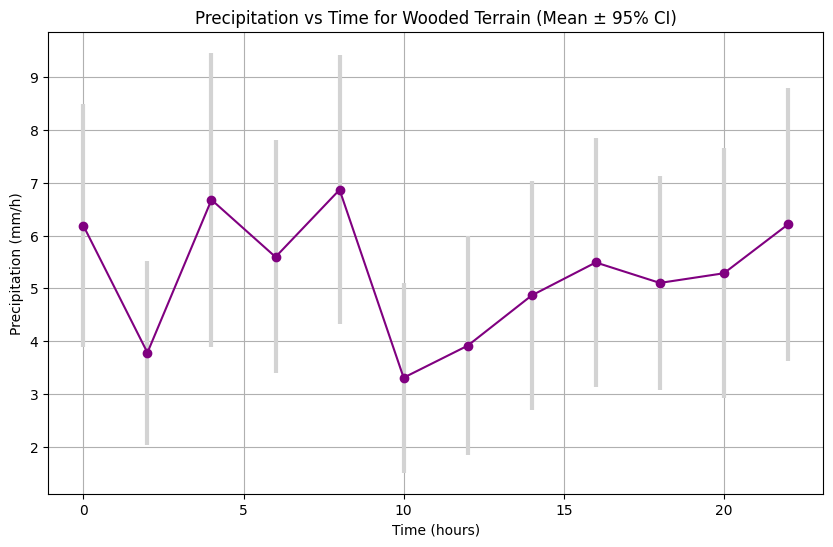

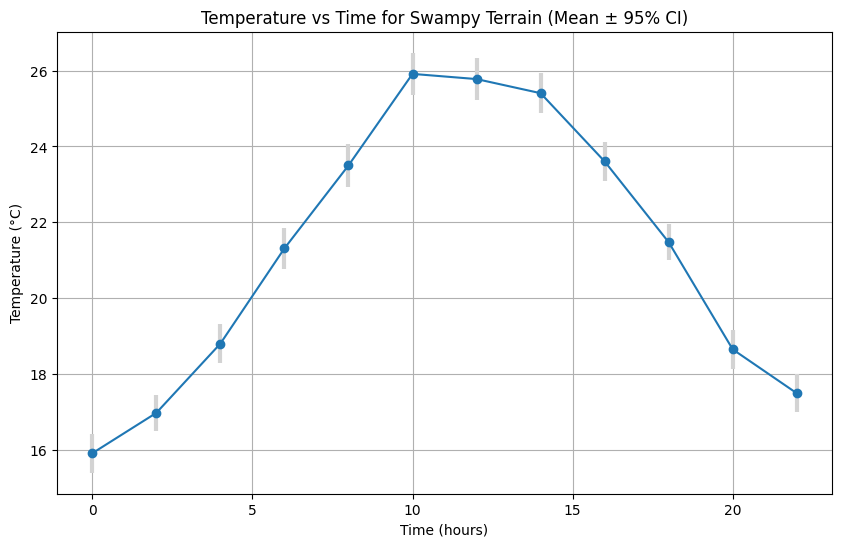

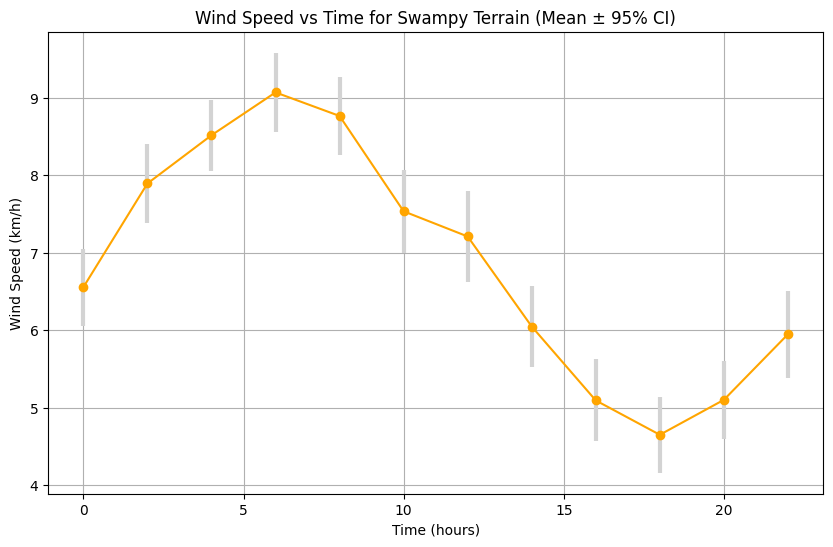

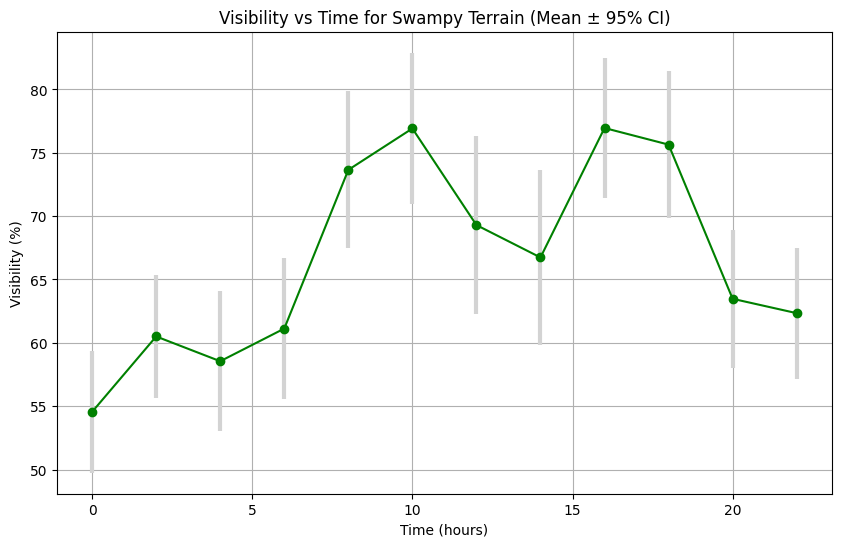

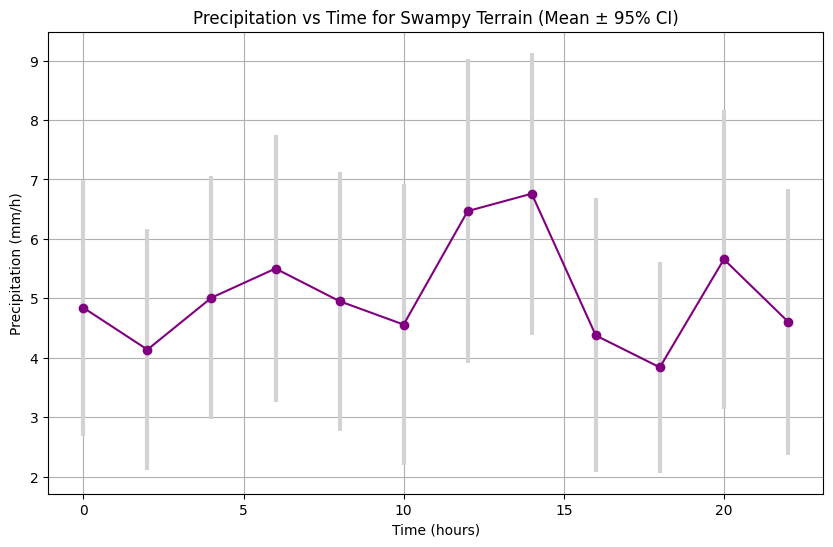

In [5]:
def generate_temperature(terrain_type, time, precipitation, temp_params):
    params = temp_params[terrain_type]
    base_temp = params['base_temp']
    diurnal_variation = params['diurnal_variation']
    precipitation_effect = params['precipitation_effect']

    temp_variation = diurnal_variation * np.sin(((time - 6) / 24) * 2 * np.pi)
    temperature = base_temp + temp_variation
    temperature -= precipitation_effect * precipitation
    temperature += np.random.normal(0, 2)
    temperature = np.clip(temperature, -10, 45)
    return temperature

def generate_wind_speed(terrain_type, time, precipitation, wind_params):
    params = wind_params[terrain_type]
    base_wind = params['base_wind']
    time_variation = params['time_variation']
    precipitation_effect = params['precipitation_effect']

    wind_variation = time_variation * np.sin((time / 24) * 2 * np.pi)
    wind_speed = base_wind + wind_variation
    wind_speed += precipitation_effect * precipitation
    wind_speed += np.random.normal(0, 2)
    wind_speed = max(wind_speed, 0)
    wind_speed = np.clip(wind_speed, 0, 100)
    return wind_speed

def generate_visibility(terrain_type, time, precipitation, visibility_params):
    params = visibility_params[terrain_type]
    max_visibility = params['max_visibility']
    time_effect = params['time_effect']
    precipitation_effect = params['precipitation_effect']

    visibility = max_visibility
    if time < 7 or time > 19:
        visibility -= time_effect * (abs(13 - time) / 6)
    visibility -= precipitation_effect * precipitation
    visibility += np.random.normal(0, 2)
    visibility = np.clip(visibility, 0, 100)
    return visibility

def generate_precipitation(terrain_type, precipitation_params):
    """
    Generates precipitation based on terrain type.

    For 'Swampy' and 'Wooded' terrains, precipitation is generated using a gamma distribution with low mean and high variance.
    For other terrains, precipitation is 0 most of the time, with occasional rain.

    Parameters:
    - terrain_type (str): Terrain type of the node.
    - precipitation_params (dict): Parameters for precipitation generation.

    Returns:
    - precipitation (float): Generated precipitation in mm/h.
    """
    params = precipitation_params[terrain_type]

    
    # Use a Bernoulli distribution to decide if it rains
    rain_probability = params['rain_probability']  # e.g., 0.1 for 10% chance of rain
    if np.random.rand() < rain_probability:
        # Generate precipitation from an exponential distribution
        scale = params['scale']  # Mean of the exponential distribution
        precipitation = np.random.exponential(scale=scale)
    else:
        precipitation = 0.0

    precipitation = np.clip(precipitation, 0, 50)
    return precipitation


def simulate_metadata_over_parameters(terrain_types, times, precipitation_params, temp_params, wind_params, visibility_params, num_runs=100):
    """
    Simulates metadata generation over different terrain types and times, running multiple simulations to compute mean and confidence intervals.
    """
    results = []

    for terrain_type in terrain_types:
        for time in times:
            # Lists to store results from multiple runs
            temp_list = []
            wind_speed_list = []
            visibility_list = []
            precipitation_list = []
            
            for _ in range(num_runs):
                # Generate precipitation
                precipitation = generate_precipitation(terrain_type, precipitation_params)
                precipitation_list.append(precipitation)
                
                # Generate temperature
                temperature = generate_temperature(terrain_type, time, precipitation, temp_params)
                temp_list.append(temperature)
                
                # Generate wind speed
                wind_speed = generate_wind_speed(terrain_type, time, precipitation, wind_params)
                wind_speed_list.append(wind_speed)
                
                # Generate visibility
                visibility = generate_visibility(terrain_type, time, precipitation, visibility_params)
                visibility_list.append(visibility)
            
            # Compute mean and confidence intervals
            temp_mean = np.mean(temp_list)
            temp_ci = stats.norm.interval(0.95, loc=temp_mean, scale=stats.sem(temp_list))
            
            wind_speed_mean = np.mean(wind_speed_list)
            wind_speed_ci = stats.norm.interval(0.95, loc=wind_speed_mean, scale=stats.sem(wind_speed_list))
            
            visibility_mean = np.mean(visibility_list)
            visibility_ci = stats.norm.interval(0.95, loc=visibility_mean, scale=stats.sem(visibility_list))
            
            precipitation_mean = np.mean(precipitation_list)
            precipitation_ci = stats.norm.interval(0.95, loc=precipitation_mean, scale=stats.sem(precipitation_list))
            
            results.append({
                'terrain_type': terrain_type,
                'time': time,
                'temperature_mean': temp_mean,
                'temperature_ci': temp_ci,
                'wind_speed_mean': wind_speed_mean,
                'wind_speed_ci': wind_speed_ci,
                'visibility_mean': visibility_mean,
                'visibility_ci': visibility_ci,
                'precipitation_mean': precipitation_mean,
                'precipitation_ci': precipitation_ci
            })

    return results

def visualize_metadata(results, terrain_types, times):
    """
    Visualizes the metadata for different terrain types and times, plotting mean and confidence intervals.
    """
    for terrain_type in terrain_types:
        terrain_results = [r for r in results if r['terrain_type'] == terrain_type]
        times = [r['time'] for r in terrain_results]
        
        # Temperature
        temperatures = [r['temperature_mean'] for r in terrain_results]
        temp_ci_lower = [r['temperature_mean'] - r['temperature_ci'][0] for r in terrain_results]
        temp_ci_upper = [r['temperature_ci'][1] - r['temperature_mean'] for r in terrain_results]
        
        plt.figure(figsize=(10, 6))
        plt.errorbar(times, temperatures, yerr=[temp_ci_lower, temp_ci_upper], fmt='-o', ecolor='lightgray', elinewidth=3, capsize=0)
        plt.title(f'Temperature vs Time for {terrain_type} Terrain (Mean ± 95% CI)')
        plt.xlabel('Time (hours)')
        plt.ylabel('Temperature (°C)')
        plt.grid(True)
        plt.show()
        
        # Wind Speed
        wind_speeds = [r['wind_speed_mean'] for r in terrain_results]
        wind_ci_lower = [r['wind_speed_mean'] - r['wind_speed_ci'][0] for r in terrain_results]
        wind_ci_upper = [r['wind_speed_ci'][1] - r['wind_speed_mean'] for r in terrain_results]
        
        plt.figure(figsize=(10, 6))
        plt.errorbar(times, wind_speeds, yerr=[wind_ci_lower, wind_ci_upper], fmt='-o', color='orange', ecolor='lightgray', elinewidth=3, capsize=0)
        plt.title(f'Wind Speed vs Time for {terrain_type} Terrain (Mean ± 95% CI)')
        plt.xlabel('Time (hours)')
        plt.ylabel('Wind Speed (km/h)')
        plt.grid(True)
        plt.show()
        
        # Visibility
        visibilities = [r['visibility_mean'] for r in terrain_results]
        vis_ci_lower = [r['visibility_mean'] - r['visibility_ci'][0] for r in terrain_results]
        vis_ci_upper = [r['visibility_ci'][1] - r['visibility_mean'] for r in terrain_results]
        
        plt.figure(figsize=(10, 6))
        plt.errorbar(times, visibilities, yerr=[vis_ci_lower, vis_ci_upper], fmt='-o', color='green', ecolor='lightgray', elinewidth=3, capsize=0)
        plt.title(f'Visibility vs Time for {terrain_type} Terrain (Mean ± 95% CI)')
        plt.xlabel('Time (hours)')
        plt.ylabel('Visibility (%)')
        plt.grid(True)
        plt.show()
        
        # Precipitation
        precipitations = [r['precipitation_mean'] for r in terrain_results]
        prec_ci_lower = [r['precipitation_mean'] - r['precipitation_ci'][0] for r in terrain_results]
        prec_ci_upper = [r['precipitation_ci'][1] - r['precipitation_mean'] for r in terrain_results]
        
        plt.figure(figsize=(10, 6))
        plt.errorbar(times, precipitations, yerr=[prec_ci_lower, prec_ci_upper], fmt='-o', color='purple', ecolor='lightgray', elinewidth=3, capsize=0)
        plt.title(f'Precipitation vs Time for {terrain_type} Terrain (Mean ± 95% CI)')
        plt.xlabel('Time (hours)')
        plt.ylabel('Precipitation (mm/h)')
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    terrain_types = ['Grassy', 'Rocky', 'Sandy', 'Wooded', 'Swampy']
    times = range(0, 24, 2)  # Every 2 hours

    precipitation_params = {
        'Grassy': {
            'rain_probability': 0.1,  # 10% chance of rain
            'scale': 10  # Mean of exponential distribution when it rains
        },
        'Rocky': {
            'rain_probability': 0.05,  # 5% chance of rain
            'scale': 5
        },
        'Sandy': {
            'rain_probability': 0.02,
            'scale': 4
        },
        'Wooded': {
            'rain_probability': 0.25,
            'scale': 20
        },
        'Swampy': {
            'rain_probability': 0.25,
            'scale': 20
        },
    }

    temp_params = {
        'Grassy': {'base_temp': 20, 'diurnal_variation': 10, 'precipitation_effect': 0.2},
        'Rocky': {'base_temp': 15, 'diurnal_variation': 8, 'precipitation_effect': 0.3},
        'Sandy': {'base_temp': 25, 'diurnal_variation': 12, 'precipitation_effect': 0.1},
        'Wooded': {'base_temp': 18, 'diurnal_variation': 6, 'precipitation_effect': 0.25},
        'Swampy': {'base_temp': 22, 'diurnal_variation': 5, 'precipitation_effect': 0.15},
    }

    wind_params = {
        'Grassy': {'base_wind': 10, 'time_variation': 5, 'precipitation_effect': 0.2},
        'Rocky': {'base_wind': 15, 'time_variation': 4, 'precipitation_effect': 0.3},
        'Sandy': {'base_wind': 12, 'time_variation': 6, 'precipitation_effect': 0.1},
        'Wooded': {'base_wind': 8, 'time_variation': 3, 'precipitation_effect': 0.25},
        'Swampy': {'base_wind': 6, 'time_variation': 2, 'precipitation_effect': 0.15},
    }

    visibility_params = {
        'Grassy': {'max_visibility': 100, 'time_effect': 5, 'precipitation_effect': 2},
        'Rocky': {'max_visibility': 100, 'time_effect': 6, 'precipitation_effect': 2.5},
        'Sandy': {'max_visibility': 100, 'time_effect': 4, 'precipitation_effect': 1.5},
        'Wooded': {'max_visibility': 90, 'time_effect': 8, 'precipitation_effect': 4},
        'Swampy': {'max_visibility': 90, 'time_effect': 10, 'precipitation_effect': 5},
    }

    num_runs = 100  # Number of simulations per combination
    results = simulate_metadata_over_parameters(
        terrain_types, times, precipitation_params, temp_params, wind_params, visibility_params, num_runs=num_runs
    )

    visualize_metadata(results, terrain_types, times)


In [6]:
def compute_accuracy(temperature, wind_speed, visibility, precipitation, terrain_type, noise_std=0.075, visibility_metric=7, visibility_scale=0.55):
    """
    Compute the accuracy based on input variables, including interaction terms with visibility.

    Parameters:
    - temperature (array-like): Temperature in degrees Celsius (-10 to 45).
    - wind_speed (array-like): Wind speed in km/h (assumed 0 to 100).
    - visibility (array-like): Visibility percentage (0 to 100).
    - precipitation (array-like): Precipitation in mm/h (assumed 0 to 50).
    - terrain_type (array-like): Terrain type as a string ('Grassy', 'Rocky', 'Sandy', 'Wooded', 'Swampy').

    Returns:
    - accuracy (numpy array): Computed accuracy values between 0 and 1.
    """

    # Ensure inputs are numpy arrays
    temperature = np.asarray(temperature)
    wind_speed = np.asarray(wind_speed)
    visibility = np.asarray(visibility)
    precipitation = np.asarray(precipitation)
    terrain_type = np.asarray(terrain_type)

    # Normalize visibility (0 to 1)
    visibility_scaled = visibility / 100.0

    # Visibility effect: non-linear, significant decrease below 60%
    # Using a logistic function centered at 60% visibility
    k_vis = visibility_metric  # Steepness of the curve
    v0 = visibility_scale    # Center of the logistic function (60% visibility)
    visibility_effect = 1 / (1 + np.exp(-k_vis * (visibility_scaled - v0)))

    # Normalize temperature (-10 to 45 scaled to 0 to 1)
    temp_min = -10
    temp_max = 45
    temp_scaled = (temperature - temp_min) / (temp_max - temp_min)

    # Temperature effect: higher accuracy at lower temperatures
    temp_effect = 1 - temp_scaled  # Invert because colder temperatures increase accuracy

    # Adjust temp_effect based on visibility
    temp_effect = temp_effect * visibility_effect

    # Normalize wind speed (0 to 1)
    wind_speed_max = 100  # Assuming maximum wind speed is 100 km/h
    wind_speed_scaled = wind_speed / wind_speed_max

    # Wind speed effect: higher accuracy at lower wind speeds
    wind_effect = 1 - wind_speed_scaled

    # Adjust wind_effect based on visibility
    wind_effect = wind_effect * visibility_effect

    # Normalize precipitation (0 to 1)
    precip_max = 50  # Assuming maximum precipitation is 50 mm/h
    precip_scaled = precipitation / precip_max

    # Precipitation effect: non-linear decrease using exponential decay
    k_precip = 2  # Adjust steepness as needed
    precip_effect = np.exp(-k_precip * precip_scaled)

    # Adjust precip_effect based on visibility
    precip_effect = precip_effect * visibility_effect

    # Terrain type effect: assign positive values for beneficial terrains and negative for detrimental
    
    terrain_dict = {
        'Grassy':  1.0,   # Beneficial (positive effect)
        'Rocky':   0.5,   # Slightly beneficial
        'Sandy':   0.0,   # Neutral
        'Wooded': -0.25,   # Slightly detrimental
        'Swampy': -0.75    # Detrimental (negative effect)
    }
    # Map terrain types to their corresponding effects
    terrain_vectorized = np.vectorize(terrain_dict.get)
    terrain_effect = terrain_vectorized(terrain_type) * visibility_effect  # Adjusted based on visibility

    # Weights for each variable's effect
    w_vis = 1.5   # Visibility weight (greatest impact)
    w_temp = 1.0  # Temperature weight
    w_wind = 1.0  # Wind speed weight
    w_precip = 1.0  # Precipitation weight
    w_terrain = 1.5  # Terrain type weight

    # Intercept for the logistic regression equation
    intercept = -2.0  # Adjust to calibrate the baseline accuracy

    # Calculate the logit of accuracy (linear combination of effects)
    logit_accuracy = (intercept +
                      w_vis * visibility_effect +
                      w_temp * temp_effect +
                      w_wind * wind_effect +
                      w_precip * precip_effect +
                      w_terrain * terrain_effect)

    # Convert logit to probability using the logistic function
    accuracy = 1 / (1 + np.exp(-logit_accuracy))
    noise = np.random.normal(0, noise_std, size=accuracy.shape)
    
    # Ensure accuracy is between 0 and 1
    accuracy = np.clip(accuracy + noise, 0, 1)

    return accuracy



In [7]:
def compute_estimates(accuracy_values, ground_truth, kappa=2, noise_scale=3, threshold=0.5):
    """
    Compute probability estimates based on accuracy values and ground truth.

    Parameters:
    - accuracy_values (array-like): Array of accuracy values between 0 and 1.
    - ground_truth (array-like): Boolean array indicating the presence of a mine (True) or not (False).
    - kappa (float): Scaling factor for the mean log-odds.
    - noise_scale (float): Scaling factor for the noise variance.

    Returns:
    - estimates (numpy array): Estimated probabilities.
    """
    """
    Compute probability estimates based on accuracy values and ground truth,
    adjusting for a threshold below which estimates are centered around 0.5.

    Parameters:
    - accuracy_values (array-like): Array of accuracy values between 0 and 1.
    - ground_truth (array-like): Boolean array indicating the presence of a mine (True) or not (False).
    - kappa (float): Scaling factor for the mean log-odds.
    - noise_scale (float): Scaling factor for the noise variance.
    - threshold (float): Accuracy threshold below which estimates are centered at 0.5.

    Returns:
    - estimates (numpy array): Estimated probabilities.
    """
    # Convert inputs to numpy arrays
    accuracy_values = np.asarray(accuracy_values)
    ground_truth = np.asarray(ground_truth, dtype=bool)

    # Ensure accuracy values are within [0, 1]
    accuracy_values = np.clip(accuracy_values, 0, 1)

    # Encode ground truth: +1 for mine present, -1 for no mine
    GT_sign = np.where(ground_truth, 1, -1)

    # Compute effective accuracy
    effective_accuracy = np.where(
        accuracy_values <= threshold,
        0,
        (accuracy_values - threshold) / (1 - threshold)
    )

    # Compute mean log-odds (mu)
    mu = kappa * effective_accuracy * GT_sign

    # Compute variance (sigma_squared)
    sigma_squared = noise_scale * (1 - effective_accuracy)

    # Generate noise (epsilon)
    epsilon = np.random.normal(0, np.sqrt(sigma_squared))

    # Compute log-odds (L)
    L = mu + epsilon

    # Convert log-odds to estimated probabilities
    estimates = 1 / (1 + np.exp(-L))

    return estimates

In [8]:
# Sample inputs
temperature = np.array([10, -5, 20, 35])
wind_speed = np.array([10, 50, 5, 80])
visibility = np.array([90, 40, 70, 30])
precipitation = np.array([0, 30, 10, 40])
terrain_type = np.array(['Grassy', 'Swampy', 'Rocky', 'Wooded'])

# Compute accuracy
accuracy = compute_accuracy(temperature, wind_speed, visibility, precipitation, terrain_type, visibility_metric=7, visibility_scale=0.3)

# Print results
for i in range(len(accuracy)):
    print(f"Input {i+1}:")
    print(f"  Temperature: {temperature[i]}°C")
    print(f"  Wind Speed: {wind_speed[i]} km/h")
    print(f"  Visibility: {visibility[i]}%")
    print(f"  Precipitation: {precipitation[i]} mm/h")
    print(f"  Terrain Type: {terrain_type[i]}")
    print(f"  Predicted Accuracy: {accuracy[i]:.4f}\n")

Input 1:
  Temperature: 10°C
  Wind Speed: 10 km/h
  Visibility: 90%
  Precipitation: 0 mm/h
  Terrain Type: Grassy
  Predicted Accuracy: 0.9650

Input 2:
  Temperature: -5°C
  Wind Speed: 50 km/h
  Visibility: 40%
  Precipitation: 30 mm/h
  Terrain Type: Swampy
  Predicted Accuracy: 0.3330

Input 3:
  Temperature: 20°C
  Wind Speed: 5 km/h
  Visibility: 70%
  Precipitation: 10 mm/h
  Terrain Type: Rocky
  Predicted Accuracy: 0.7911

Input 4:
  Temperature: 35°C
  Wind Speed: 80 km/h
  Visibility: 30%
  Precipitation: 40 mm/h
  Terrain Type: Wooded
  Predicted Accuracy: 0.1754



In [9]:
# Sample inputs for compute_accuracy
temperature = np.array([10, 20, 30, 25])
wind_speed = np.array([5, 15, 25, 20])
visibility = np.array([90, 70, 50, 60])
precipitation = np.array([0, 10, 20, 5])
terrain_type = np.array(['Grassy', 'Rocky', 'Swampy', 'Wooded'])

# Compute accuracy values
accuracy_values = compute_accuracy(
    temperature=temperature,
    wind_speed=wind_speed,
    visibility=visibility,
    precipitation=precipitation,
    terrain_type=terrain_type
)

ground_truth = np.array([True, False, True, False])

estimates = compute_estimates(accuracy_values, ground_truth)

for acc, gt, est in zip(accuracy_values, ground_truth, estimates):
    gt_str = 'Mine Present' if gt else 'No Mine'
    print(f"Accuracy: {acc:.4f}, Ground Truth: {gt_str}, Estimated Probability: {est:.4f}")


Accuracy: 0.9569, Ground Truth: Mine Present, Estimated Probability: 0.8318
Accuracy: 0.7386, Ground Truth: No Mine, Estimated Probability: 0.2289
Accuracy: 0.2395, Ground Truth: Mine Present, Estimated Probability: 0.8499
Accuracy: 0.3933, Ground Truth: No Mine, Estimated Probability: 0.8403


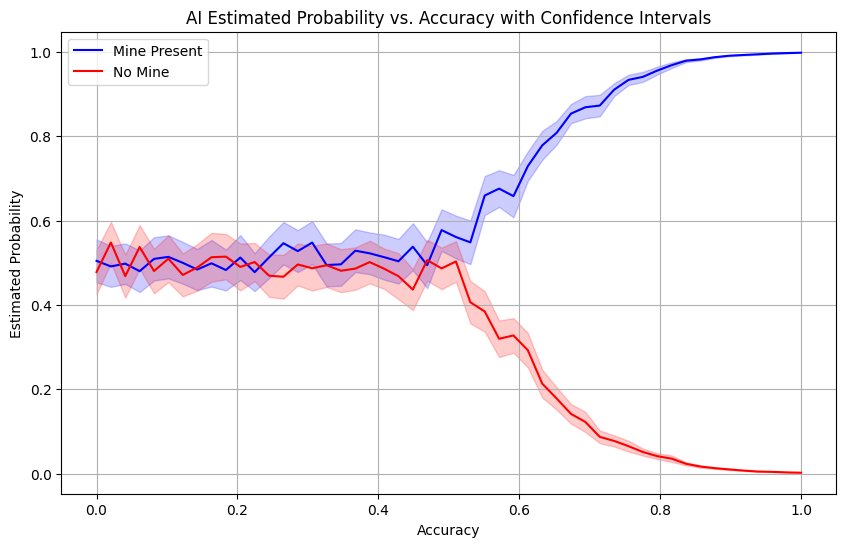

In [12]:
def plot_estimates_vs_accuracy_with_ground_truth():
    """
    Plot average estimated probability vs. accuracy for both positive and negative ground truths,
    including 95% confidence intervals over 100 runs.
    """
    accuracy_values = np.linspace(0, 1, 50)  # Accuracy values from 0 to 1
    n_runs = 100  # Number of simulations per accuracy value
    kappa = 6
    noise_scale = 2
    threshold = 0.5
    z = 1.96  # Z-score for 95% confidence interval

    # Arrays to store mean estimates and confidence intervals
    mean_estimates_positive = []
    lower_ci_positive = []
    upper_ci_positive = []

    mean_estimates_negative = []
    lower_ci_negative = []
    upper_ci_negative = []

    for accuracy in accuracy_values:
        # Arrays of the current accuracy value
        accuracy_array = np.full(n_runs, accuracy)

        # Ground truth: Mine Present (True)
        ground_truth_positive = np.ones(n_runs, dtype=bool)

        # Compute estimates for positive ground truth
        estimates_positive = compute_estimates(
            accuracy_array, ground_truth_positive, kappa, noise_scale, threshold)

        # Calculate mean and 95% confidence interval
        mean_pos = np.mean(estimates_positive)
        std_pos = np.std(estimates_positive, ddof=1)
        se_pos = std_pos / np.sqrt(n_runs)
        ci_pos = z * se_pos  # 95% confidence interval

        mean_estimates_positive.append(mean_pos)
        lower_ci_positive.append(mean_pos - ci_pos)
        upper_ci_positive.append(mean_pos + ci_pos)

        # Ground truth: No Mine (False)
        ground_truth_negative = np.zeros(n_runs, dtype=bool)

        # Compute estimates for negative ground truth
        estimates_negative = compute_estimates(
            accuracy_array, ground_truth_negative, kappa, noise_scale, threshold)

        # Calculate mean and 95% confidence interval
        mean_neg = np.mean(estimates_negative)
        std_neg = np.std(estimates_negative, ddof=1)
        se_neg = std_neg / np.sqrt(n_runs)
        ci_neg = z * se_neg  # 95% confidence interval

        mean_estimates_negative.append(mean_neg)
        lower_ci_negative.append(mean_neg - ci_neg)
        upper_ci_negative.append(mean_neg + ci_neg)

    # Convert lists to numpy arrays
    accuracy_values = np.array(accuracy_values)
    mean_estimates_positive = np.array(mean_estimates_positive)
    lower_ci_positive = np.array(lower_ci_positive)
    upper_ci_positive = np.array(upper_ci_positive)

    mean_estimates_negative = np.array(mean_estimates_negative)
    lower_ci_negative = np.array(lower_ci_negative)
    upper_ci_negative = np.array(upper_ci_negative)

    # Plotting the results
    plt.figure(figsize=(10, 6))

    # Plot for Mine Present
    plt.plot(accuracy_values, mean_estimates_positive, label='Mine Present', color='blue')
    plt.fill_between(accuracy_values, lower_ci_positive, upper_ci_positive, color='blue', alpha=0.2)

    # Plot for No Mine
    plt.plot(accuracy_values, mean_estimates_negative, label='No Mine', color='red')
    plt.fill_between(accuracy_values, lower_ci_negative, upper_ci_negative, color='red', alpha=0.2)

    plt.xlabel('Accuracy')
    plt.ylabel('Estimated Probability')
    plt.title('AI Estimated Probability vs. Accuracy with Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_estimates_vs_accuracy_with_ground_truth()

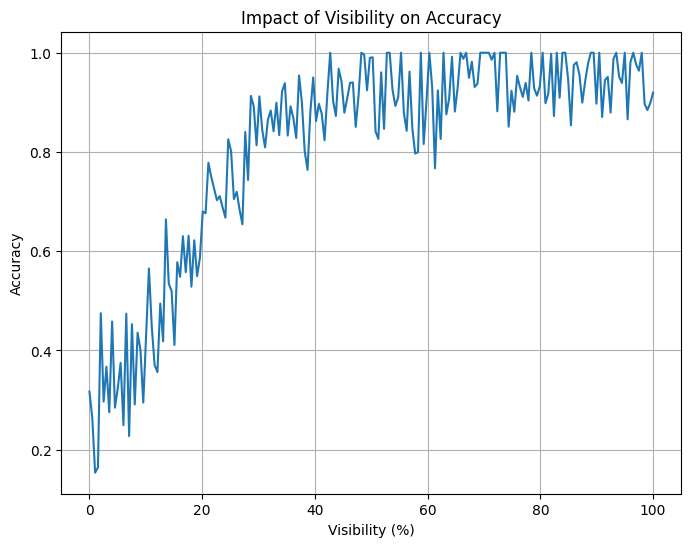

In [5]:
def plot_visibility_effect():
    visibility_range = np.linspace(0, 100, 200)
    temperature = 20       # Fixed temperature
    wind_speed = 10        # Fixed wind speed
    precipitation = 5      # Fixed precipitation
    terrain_type = 'Grassy'  # Fixed terrain type

    accuracy = compute_accuracy(
        temperature=temperature,
        wind_speed=wind_speed,
        visibility=visibility_range,
        precipitation=precipitation,
        terrain_type=terrain_type,
        visibility_metric=7,
        visibility_scale=0.2
    )

    plt.figure(figsize=(8, 6))
    plt.plot(visibility_range, accuracy)
    plt.xlabel('Visibility (%)')
    plt.ylabel('Accuracy')
    plt.title('Impact of Visibility on Accuracy')
    plt.grid(True)
    plt.show()

plot_visibility_effect()

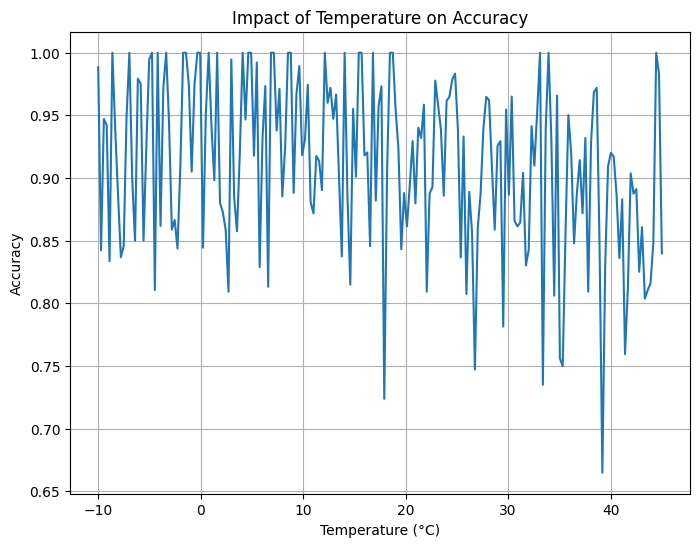

In [47]:
def plot_temperature_effect():
    temperature_range = np.linspace(-10, 45, 200)
    wind_speed = 10       # Fixed wind speed
    visibility = 80       # Fixed visibility
    precipitation = 5     # Fixed precipitation
    terrain_type = 'Grassy'  # Fixed terrain type

    accuracy = compute_accuracy(
        temperature=temperature_range,
        wind_speed=wind_speed,
        visibility=visibility,
        precipitation=precipitation,
        terrain_type=terrain_type
    )

    plt.figure(figsize=(8, 6))
    plt.plot(temperature_range, accuracy)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Accuracy')
    plt.title('Impact of Temperature on Accuracy')
    plt.grid(True)
    plt.show()
plot_temperature_effect()

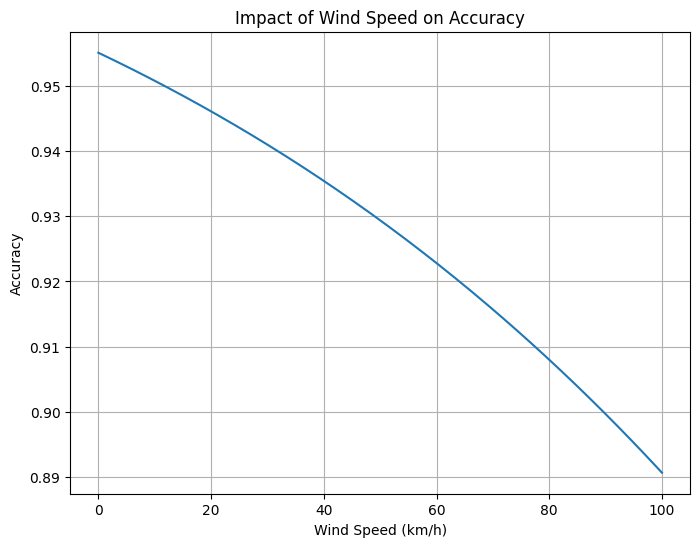

In [51]:
def plot_wind_speed_effect():
    wind_speed_range = np.linspace(0, 100, 200)
    temperature = 20       # Fixed temperature
    visibility = 100        # Fixed visibility
    precipitation = 5      # Fixed precipitation
    terrain_type = 'Grassy'  # Fixed terrain type

    accuracy = compute_accuracy(
        temperature=temperature,
        wind_speed=wind_speed_range,
        visibility=visibility,
        precipitation=precipitation,
        terrain_type=terrain_type
    )

    plt.figure(figsize=(8, 6))
    plt.plot(wind_speed_range, accuracy)
    plt.xlabel('Wind Speed (km/h)')
    plt.ylabel('Accuracy')
    plt.title('Impact of Wind Speed on Accuracy')
    plt.grid(True)
    plt.show()
plot_wind_speed_effect()

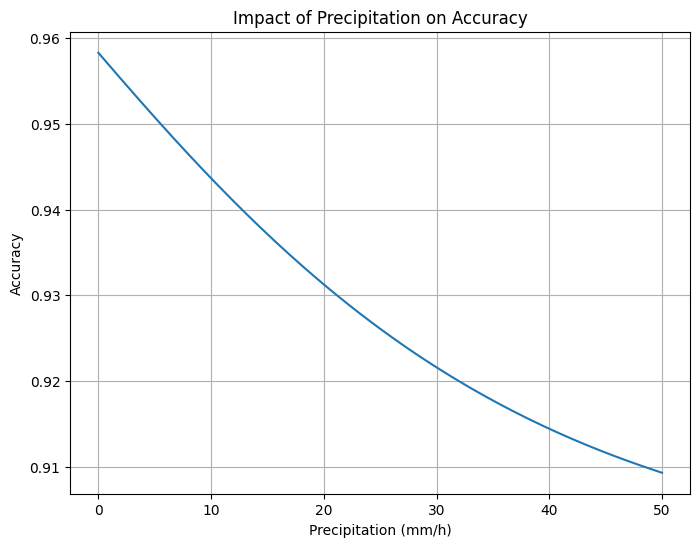

In [49]:
def plot_precipitation_effect():
    precipitation_range = np.linspace(0, 50, 200)
    temperature = 20       # Fixed temperature
    wind_speed = 10        # Fixed wind speed
    visibility = 100        # Fixed visibility
    terrain_type = 'Grassy'  # Fixed terrain type

    accuracy = compute_accuracy(
        temperature=temperature,
        wind_speed=wind_speed,
        visibility=visibility,
        precipitation=precipitation_range,
        terrain_type=terrain_type
    )

    plt.figure(figsize=(8, 6))
    plt.plot(precipitation_range, accuracy)
    plt.xlabel('Precipitation (mm/h)')
    plt.ylabel('Accuracy')
    plt.title('Impact of Precipitation on Accuracy')
    plt.grid(True)
    plt.show()
plot_precipitation_effect()

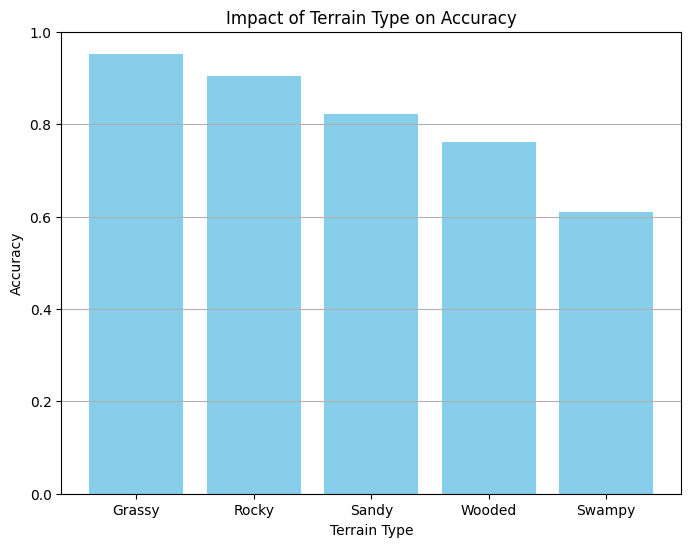

In [63]:
def plot_terrain_type_effect():
    terrain_types = ['Grassy', 'Rocky', 'Sandy', 'Wooded', 'Swampy']
    temperature = 20       # Fixed temperature
    wind_speed = 10        # Fixed wind speed
    visibility = 100        # Fixed visibility
    precipitation = 5      # Fixed precipitation

    # Repeat terrain types to match array length
    terrain_array = np.array(terrain_types)

    accuracy = compute_accuracy(
        temperature=temperature,
        wind_speed=wind_speed,
        visibility=visibility,
        precipitation=precipitation,
        terrain_type=terrain_array
    )

    plt.figure(figsize=(8, 6))
    plt.bar(terrain_types, accuracy, color='skyblue')
    plt.xlabel('Terrain Type')
    plt.ylabel('Accuracy')
    plt.title('Impact of Terrain Type on Accuracy')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.show()
plot_terrain_type_effect()